In [1]:
import scanpy as sc
import seaborn as sns
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def is_outlier(adata, metric: str, upper: int, lower: int):
    M = adata.obs[metric]
    outlier = (M < np.percentile(M, lower)) | (
        M > np.percentile(M, upper)
    )

    return outlier


## QC 

We graph various aspects of the data such as % mt, counts, and umi. Filtering out cells that are low quality or otherwise impacting analysis. Note doublet detection is done late

In [3]:
adata=sc.read_h5ad("doublet_filtered.h5ad")


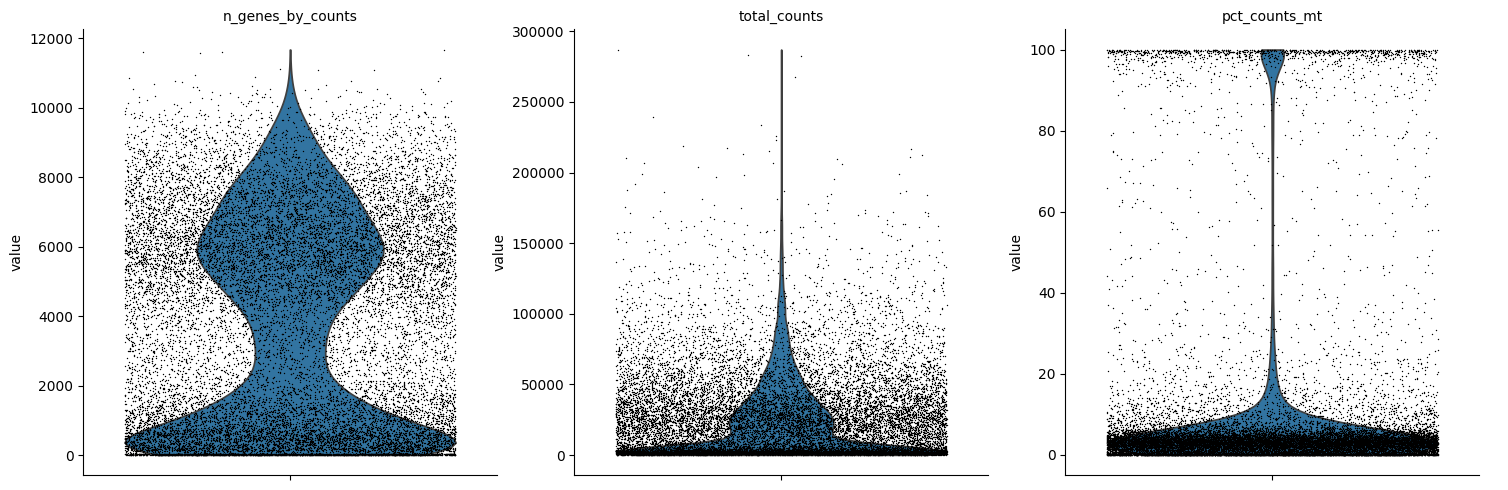

In [4]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
#graphing number of counts, pct mt and genes
# NOTE: n_genes_by_counts translates to the number of genes with at least one count in that cell
#multi panel so each has its own y axis

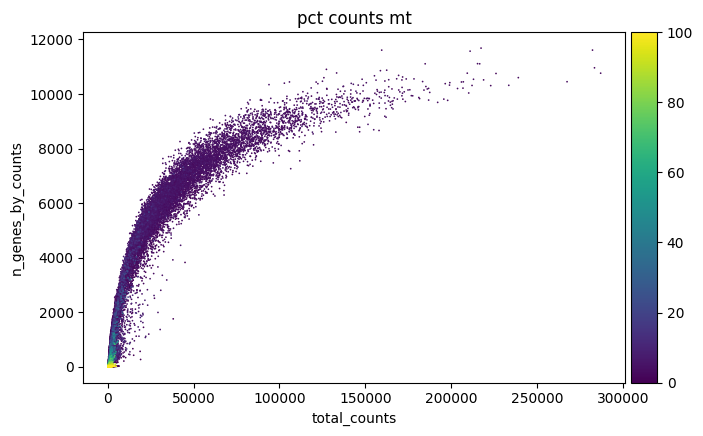

In [5]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", )

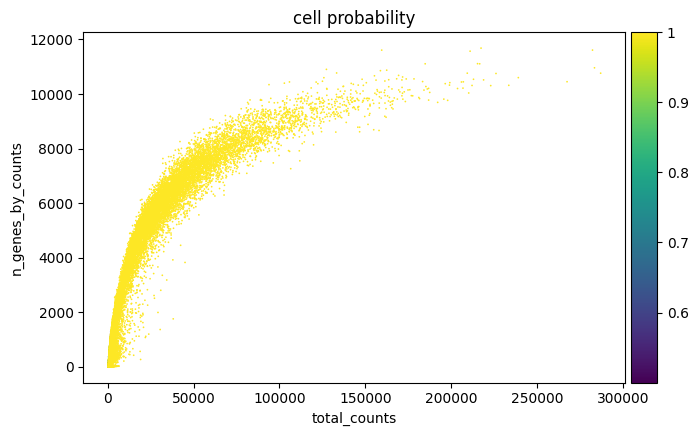

In [6]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="cell_probability")#for cellbender computed probs

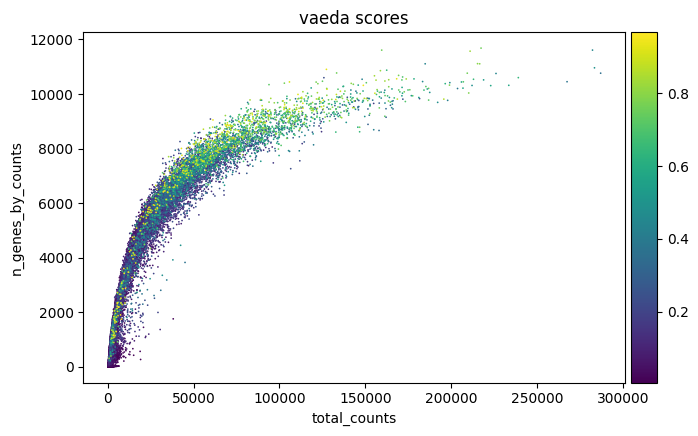

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="vaeda_scores") #doublet scores

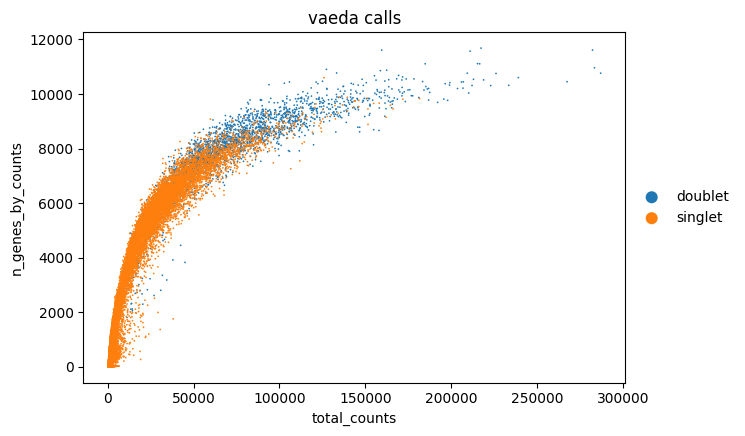

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="vaeda_calls") #doublet scores

In [9]:
adata = adata[adata.obs["vaeda_calls"]=="singlet"]

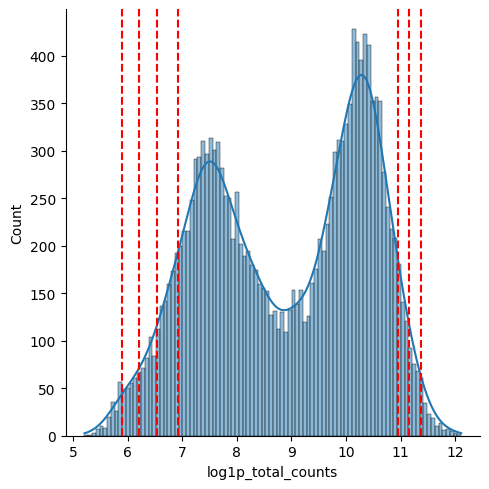

In [10]:
percentiles = [1, 2.5, 5, 10, 95, 97.5, 99]
p1 = sns.displot(adata.obs["log1p_total_counts"], bins=100, kde=True)
for p in percentiles:
    plt.axvline(np.percentile(adata.obs["log1p_total_counts"], p), color='r', linestyle='--', label=f'{p}th Percentile')


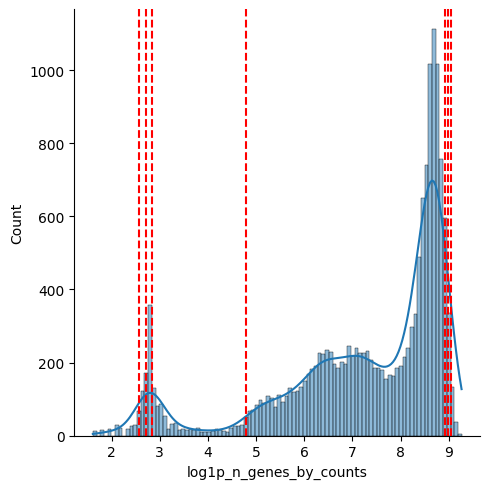

In [11]:
p2 = sns.displot(adata.obs["log1p_n_genes_by_counts"], bins=100, kde=True)
for p in percentiles:
    plt.axvline(np.percentile(adata.obs["log1p_n_genes_by_counts"], p), color='r', linestyle='--', label=f'{p}th Percentile')

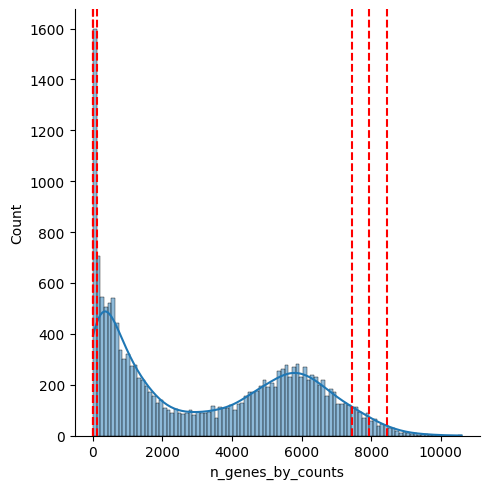

In [12]:
p3 = sns.displot(adata.obs["n_genes_by_counts"], bins=100, kde=True)
for p in percentiles:
    plt.axvline(np.percentile(adata.obs["n_genes_by_counts"], p), color='r', linestyle='--', label=f'{p}th Percentile')

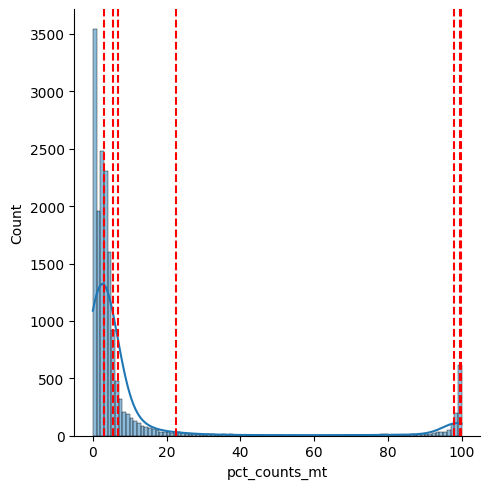

In [17]:
percentiles = [50, 75, 80, 90, 95, 97.5, 99]

p4 = sns.displot(adata.obs["pct_counts_mt"], bins=100, kde=True)
for p in percentiles:
    plt.axvline(np.percentile(adata.obs["pct_counts_mt"], p), color='r', linestyle='--', label=f'{p}th Percentile')

In [16]:
np.percentile(adata.obs["pct_counts_mt"], 80)

6.835051912403378

$\text{MAD}=\text{Median}(|X_i-\tilde{X}|)$

In [18]:
n_genes_outlier_upper = 97.5
counts_outlier_upper = 97.5
n_genes_outlier_lower = 10
counts_outlier_lower = 2.5
mt_outlier = 80


adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", upper=counts_outlier_upper, lower=counts_outlier_lower) | is_outlier(adata, "log1p_n_genes_by_counts", upper=n_genes_outlier_upper, lower=n_genes_outlier_lower))
adata.obs.outlier.value_counts()

/tmp/ipykernel_21852/2497217753.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["outlier"] = (


outlier
False    14367
True      2172
Name: count, dtype: int64

In [19]:
adata.obs["mt_outlier"] = ( adata.obs["pct_counts_mt"] > np.percentile(adata.obs["pct_counts_mt"], mt_outlier))
adata.obs.mt_outlier.value_counts()

mt_outlier
False    13231
True      3308
Name: count, dtype: int64

In [20]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 16539
Number of cells after filtering of low quality cells: 12382


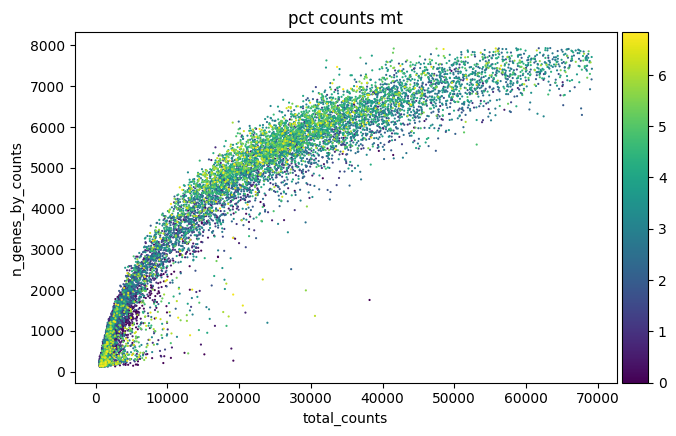

In [21]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [22]:
from ipylab import JupyterFrontEnd

app = JupyterFrontEnd()
app.commands.execute('docmanager:save')
#saving so html writes properly

In [23]:
adata.write_h5ad("qc_filtered.h5ad")
os.system('jupyter nbconvert --to html QC.ipynb')

[NbConvertApp] Converting notebook QC.ipynb to html
[NbConvertApp] Writing 1386459 bytes to QC.html


0